References:

*   https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
*   http://ethen8181.github.io/machine-learning/time_series/1_exponential_smoothing.html
*   https://towardsdatascience.com/5-types-of-plots-that-will-help-you-with-time-series-analysis-b63747818705
*   https://machinelearningmastery.com/time-series-data-visualization-with-python/ 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install statsmodels==0.12.2

In [3]:
import pandas as pd

DATA_PATH = '/content/drive/My Drive/my_colab/'
AMZN_DATA = f'{DATA_PATH}AMZN/AMZN.csv'

amzn_df = pd.read_csv(AMZN_DATA, parse_dates=['Date'])

amzn_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500


Line plot

In [4]:
import plotly.express as px

def plot_ts_window(df, dt_col, series_col, start=None, end=None):   
    df = df[[dt_col, series_col]]
    start = str(df[dt_col].min()) if start is None else start
    end = str(df[dt_col].max()) if end is None else end
    win_df = df[(df[dt_col] >= start) & (df[dt_col] <= end)]
    fig = px.line(win_df, x = dt_col, y = series_col)
    fig.show()
    #window_df.set_index(dt_col).plot(figsize=(20,10), grid=True)

plot_ts_window(amzn_df, 'Date', 'Close')

Decomposition

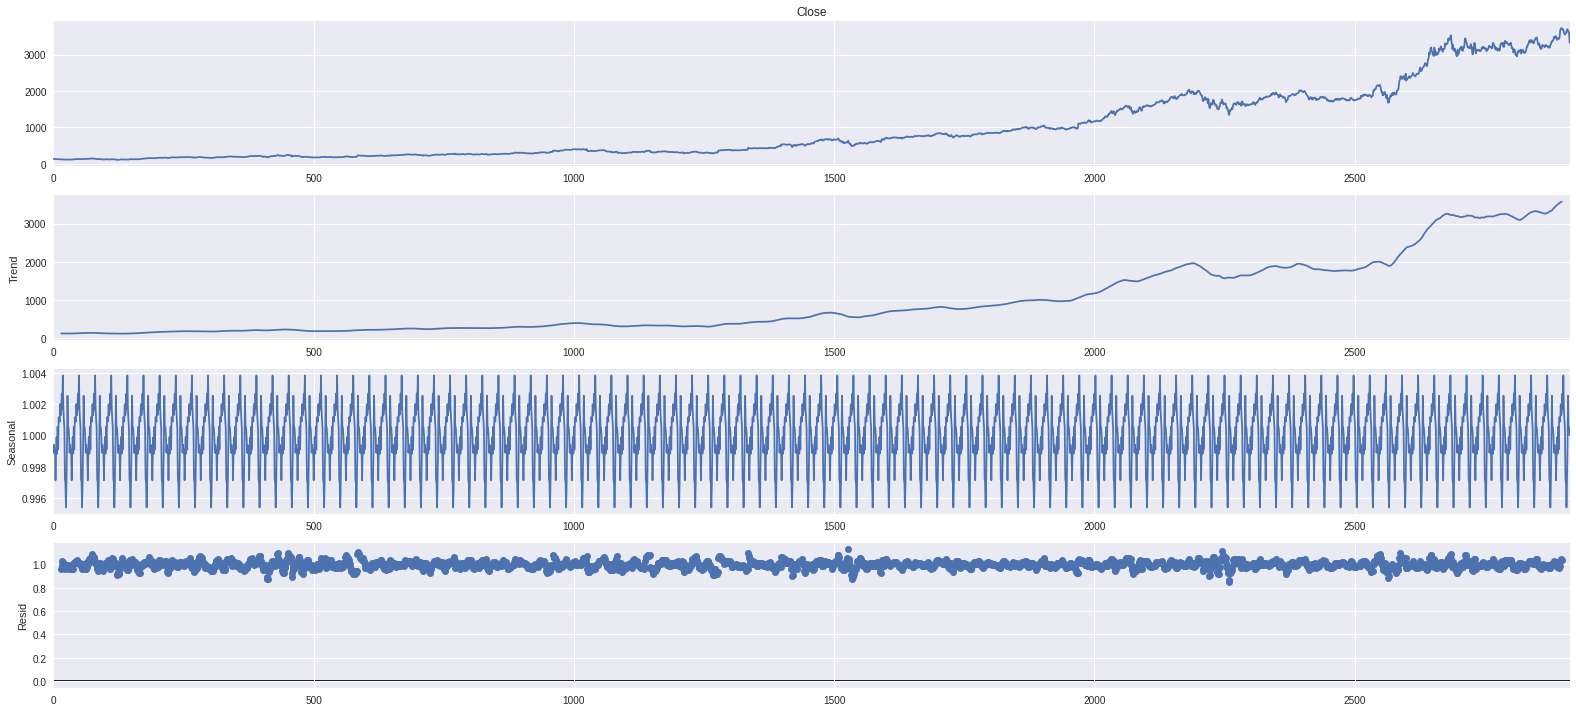

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

# plotting
import seaborn as sns 
import matplotlib.pyplot as plt

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (22, 10)

decomposition = seasonal_decompose(amzn_df['Close'], model='multiplicative', period=31)
decomposition.plot();

Autocorrelation plots

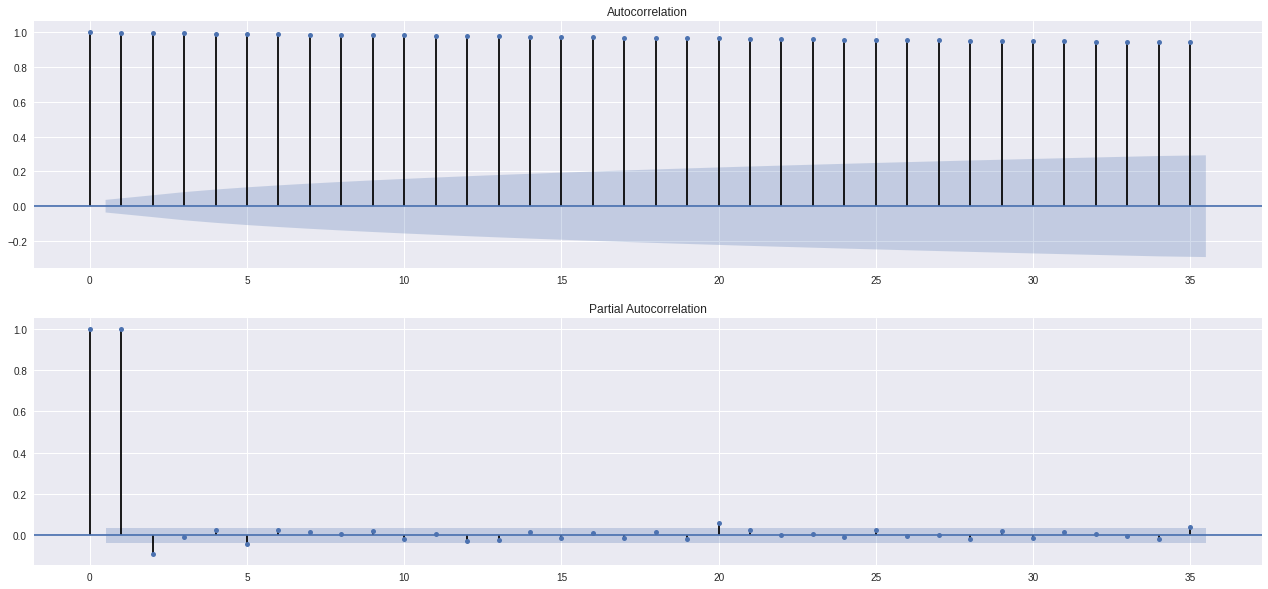

In [13]:
fig, ax = plt.subplots(2)
plot_acf(amzn_df['Close'], ax=ax[0])
plot_pacf(amzn_df['Close'], ax=ax[1]);

Box Plots

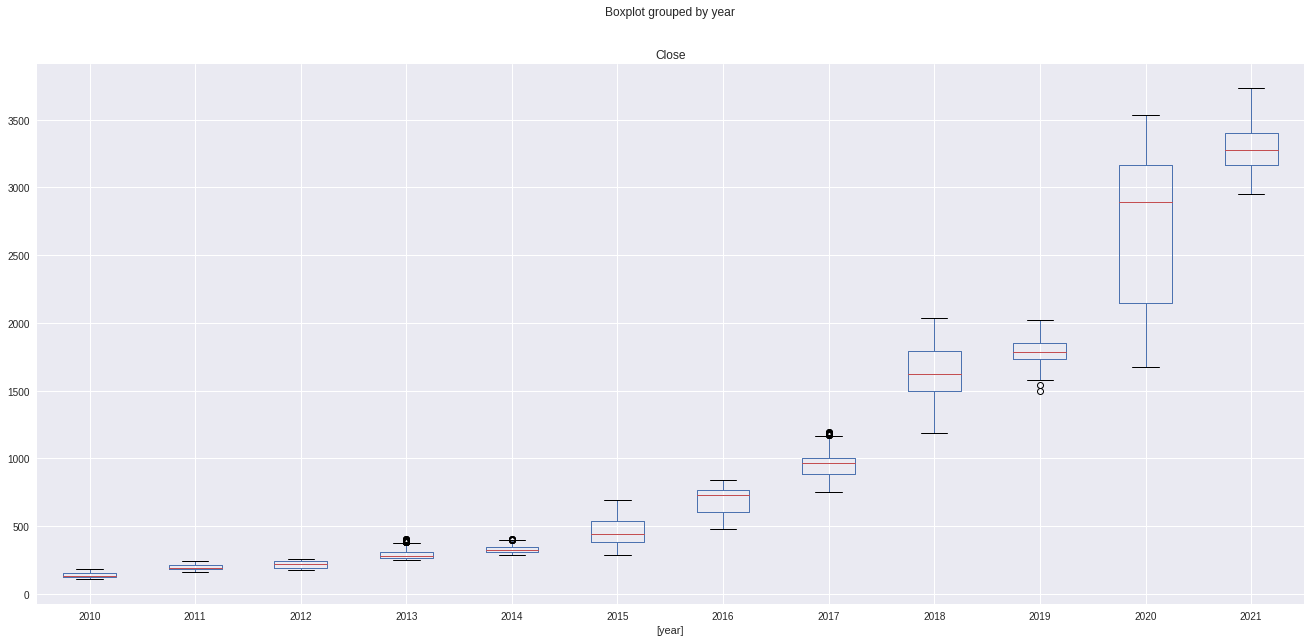

In [18]:
amzn_df["year"] = amzn_df["Date"].dt.year
amzn_df["month"] = amzn_df["Date"].dt.month
amzn_df["dayofweek"] = amzn_df["Date"].dt.dayofweek

amzn_df.boxplot(column=["Close"], by=["year"])

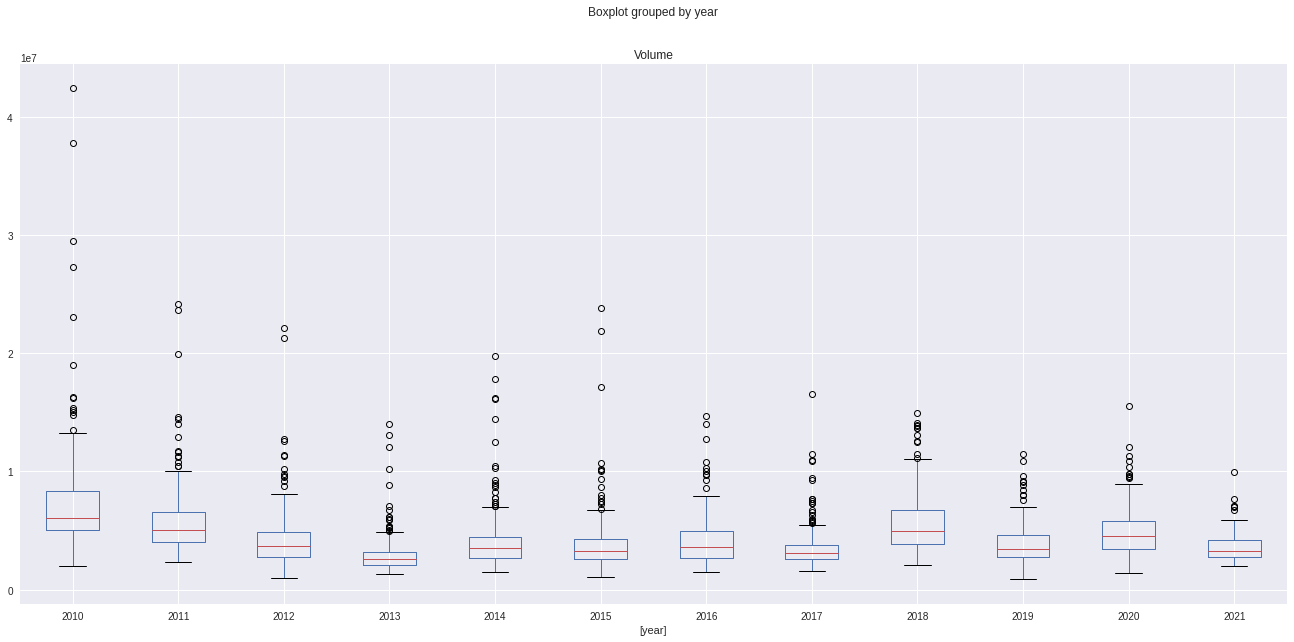

In [19]:
amzn_df.boxplot(column=["Volume"], by=["year"])

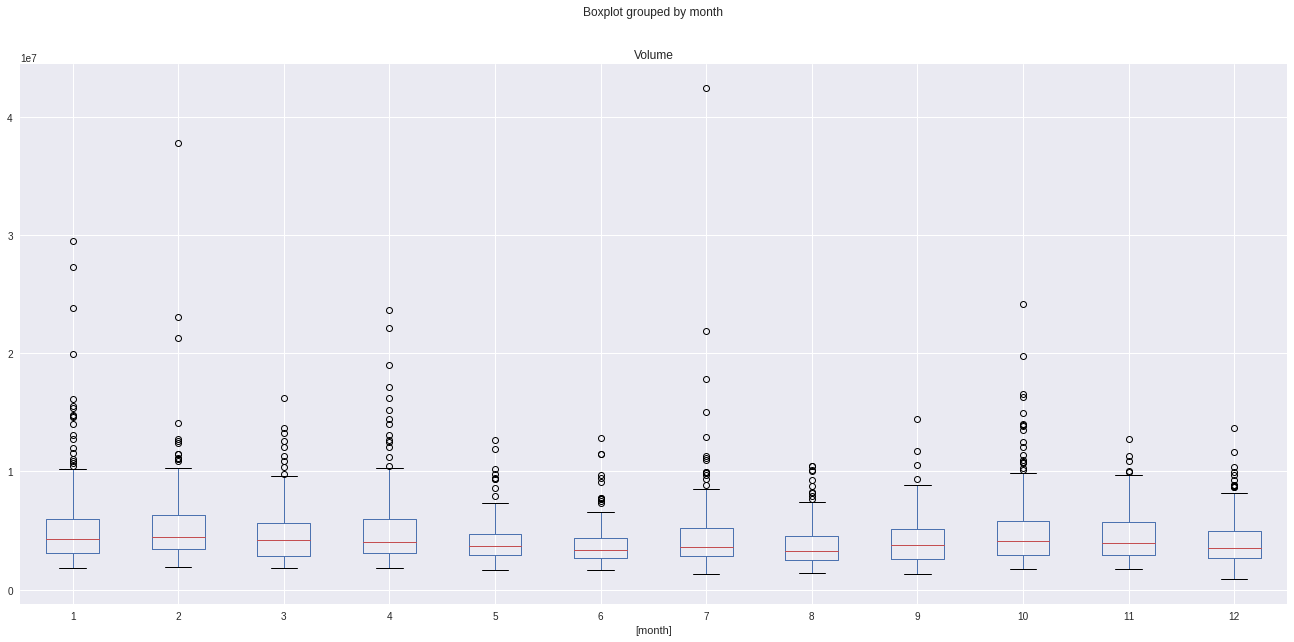

In [20]:
amzn_df.boxplot(column=["Volume"], by=["month"])

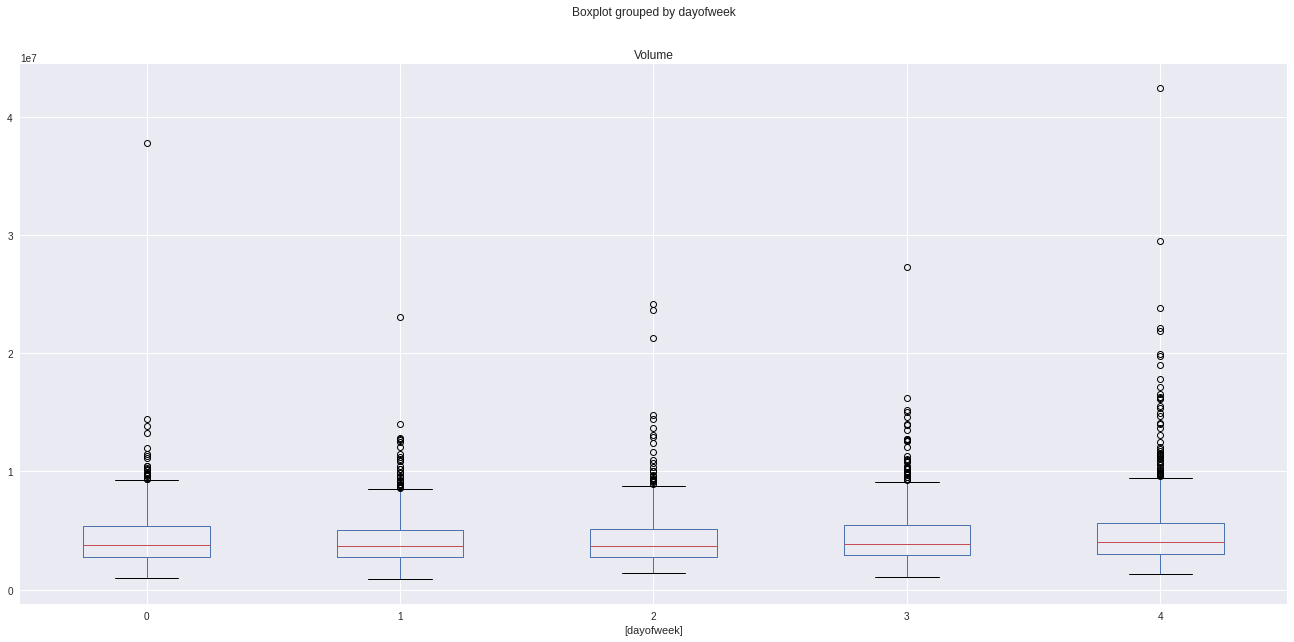

In [21]:
amzn_df.boxplot(column=["Volume"], by=["dayofweek"])

Histogram and Density Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f731e68f350>]],
      dtype=object)

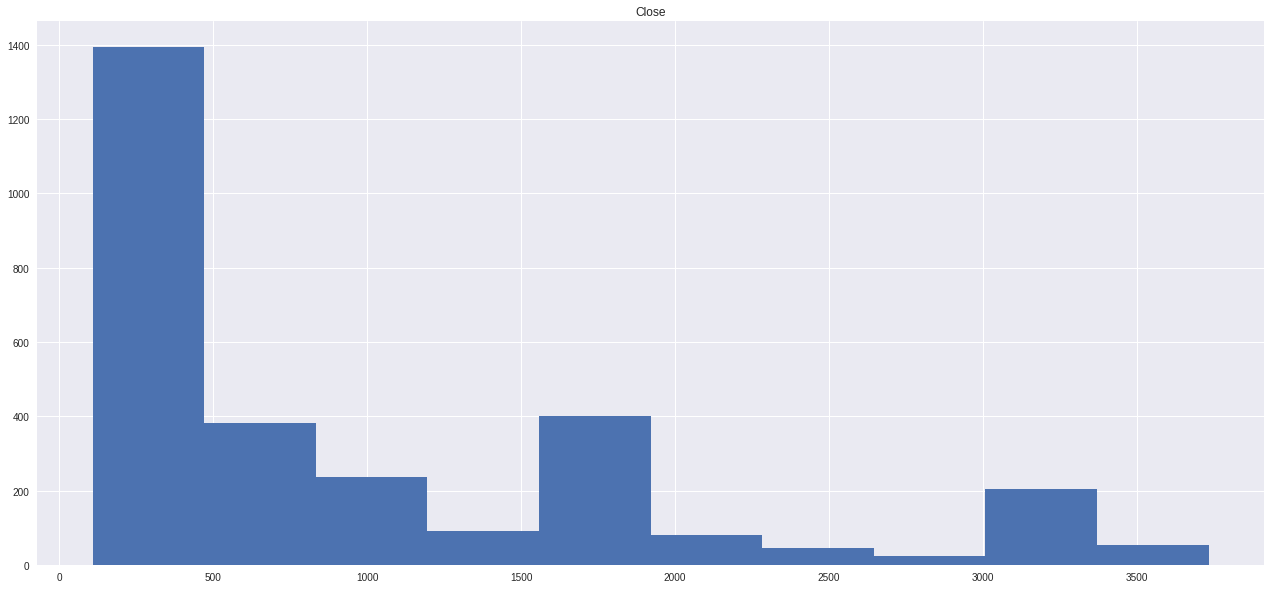

In [23]:
amzn_df.hist(column=["Close"])

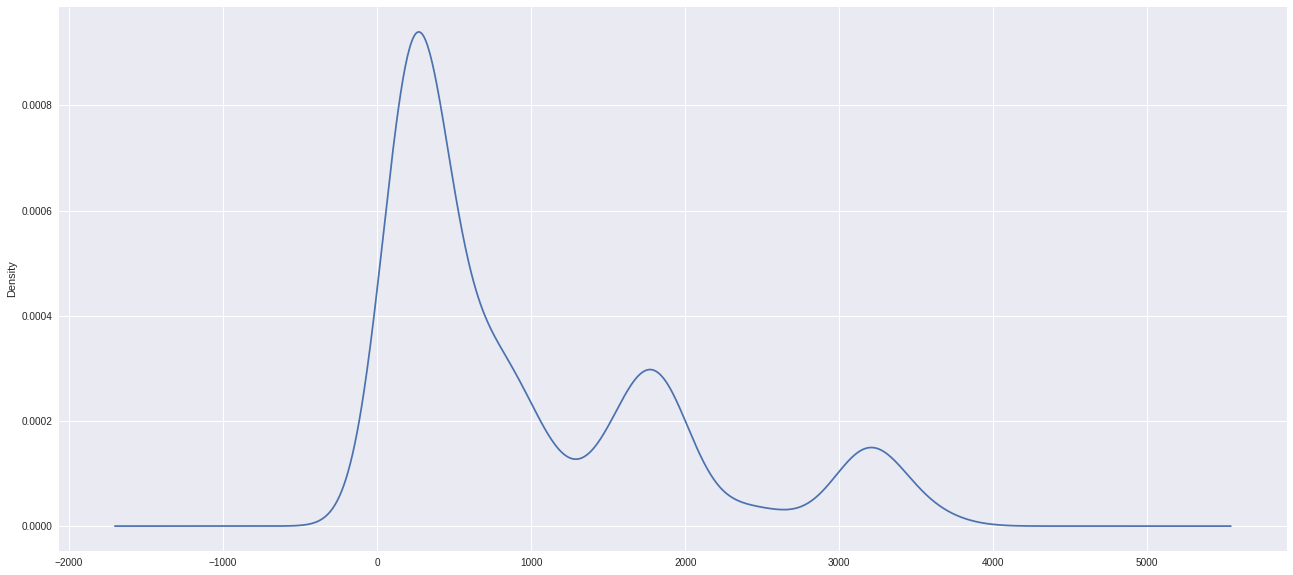

In [28]:
amzn_df['Close'].plot(kind='kde')

Let's try different exponential smoothing methods for stock price forecasting

In [7]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#import statsmodels
import numpy as np
#import matplotlib.pyplot as plt                  # plots
#import seaborn as sns                            # more plots
from sklearn.model_selection import ParameterGrid
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize


def mean_absolute_percentage_error(y_true, y_pred): 
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

def double_exponential_smoothing(series, alpha, beta, horizon=31):
    """
    Given a series, alpha, beta and n_preds (number of
    forecast/prediction steps), perform the prediction.
    """
    n_record = series.shape[0]
    results = np.zeros(n_record + horizon)

    # first value remains the same as series,
    # as there is no history to learn from;
    # and the initial trend is the slope/difference
    # between the first two value of the series
    level = series[0]
    results[0] = series[0]
    trend = series[1] - series[0]
    for t in range(1, n_record + 1):
        if t >= n_record:
            # forecasting new points
            value = results[t - 1]
        else:
            value = series[t]

        previous_level = level
        level = alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend 
        results[t] = level + trend

    # for forecasting beyond the first new point,
    # the level and trend is all fixed
    if horizon > 1:
        results[n_record + 1:] = level + np.arange(2, horizon + 1) * trend

    return results[-horizon:]


def timeseriesCVscoreDouble(params, series, loss_function=mean_squared_error):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        # model = HoltWinters(series=values[train], slen=slen, 
        #                     alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        # model.triple_exponential_smoothing()
        # predictions = model.result[-len(test):]
        
        predictions = double_exponential_smoothing(values[train], alpha, beta, horizon=len(test))
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))


def exp_smoothing(df, type, feature, horizon=None, lag_opt=None):
  exp_types = ('double', 'my_double', 'tripple')
  assert type in exp_types, f'type is not valid. Possible types: {exp_types}'
  
  train = df[-(lag_opt+horizon):-horizon]

  if type == 'double':
    model = Holt(train, initialization_method="estimated").fit()
    y_smooth = model.forecast(horizon)
    m_params = model.params
    del m_params['initial_seasons']
    del m_params['smoothing_seasonal']
    del m_params['lamda']
  elif type == 'tripple':
    model = ExponentialSmoothing(train, seasonal='add', trend='add', initialization_method="estimated").fit()
    y_smooth = model.forecast(horizon)
    m_params = model.params
    del m_params['initial_seasons']
    del m_params['lamda']
  elif type == 'my_double':
    params = [0, 0] 
    # Minimizing the loss function 
    opt = minimize(timeseriesCVscoreDouble, x0=params, 
               args=(train, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1))
              )
    alpha_final, beta_final = opt.x
    m_params = {'alpha':alpha_final, 'beta':beta_final}
    y_smooth = double_exponential_smoothing(train[feature], alpha_final, beta_final, horizon)

  mape = mean_absolute_percentage_error(df[-horizon:][feature].values, y_smooth)
  return mape, y_smooth, m_params


def optimize_lag_and_plot_smoothing(df_src, dt_col, feature_name, period='D', horizon=31):
  df = df_src[[dt_col, feature_name]].copy()
  df = df.set_index(dt_col)
  df.index = pd.DatetimeIndex(df.index).to_period(period) 

  params_grid = {'type':['double', 'my_double', 'tripple'],
                'lag_opt':[horizon * mul for mul in range(1, 10)]}

  grid = ParameterGrid(params_grid)
  model_parameters = pd.DataFrame(columns = ['type','mape','grid_params', 'smooth_params'])

  for p in grid:
    random.seed(0)  
    mape, y_smooth, m_params = exp_smoothing(df, p['type'], feature_name, horizon=horizon, lag_opt=p['lag_opt'])
    model_parameters = model_parameters.append({'type':p['type'], 'mape':mape, 'grid_params':p, 'smooth_params':m_params}, ignore_index=True)
  
  
  parameters = model_parameters.sort_values(by=['mape'])
  parameters = parameters.reset_index(drop=True)

  double_best = parameters[parameters['type']=='double'].iloc[0]
  my_double_best = parameters[parameters['type']=='my_double'].iloc[0]
  tripple_best = parameters[parameters['type']=='tripple'].iloc[0]

  double_best_lag_opt = double_best['grid_params']['lag_opt']
  my_double_best_lag_opt = my_double_best['grid_params']['lag_opt']
  tripple_best_lag_opt = tripple_best['grid_params']['lag_opt']


  train_double = df[-(double_best_lag_opt+horizon):-horizon]
  model_double = Holt(train_double, initialization_method=None).fit(**double_best['smooth_params'])
  y_double = model_double.forecast(horizon)
  double_mape = mean_absolute_percentage_error(df[-horizon:][feature_name].values, y_double)
  
  train_my_double = df[-(my_double_best_lag_opt+horizon):-horizon]
  my_double = double_exponential_smoothing(train_my_double[feature_name], my_double_best['smooth_params']['alpha'], my_double_best['smooth_params']['beta'], horizon=horizon)
  my_double_mape = mean_absolute_percentage_error(df[-horizon:][feature_name].values, my_double)
  
  df_hvals = pd.DataFrame({'hist_vals':train_my_double[feature_name].values})
  df_hvals.to_csv(f'{DATA_PATH}AMZN/hist_vals.csv', index=None)

  df_results = pd.DataFrame({'results':my_double})
  df_results.to_csv(f'{DATA_PATH}AMZN/results.csv', index=None)

  df_params = pd.DataFrame({'alpha':[my_double_best['smooth_params']['alpha']], 'beta':my_double_best['smooth_params']['beta']})
  df_params.to_csv(f'{DATA_PATH}AMZN/params.csv', index=None)

  train_tripple = df[-(tripple_best_lag_opt+horizon):-horizon]
  model_tripple = ExponentialSmoothing(train_tripple, seasonal='add', trend='add', initialization_method=None).fit(**tripple_best['smooth_params'])
  y_tripple = model_tripple.forecast(horizon)
  tripple_mape = mean_absolute_percentage_error(df[-horizon:][feature_name].values, y_tripple)
  
  
  df_tgt = df_src[[dt_col, feature_name]].copy()
  df_tgt = df_tgt.set_index(dt_col)
  df_tgt =  df_tgt[-horizon*2:].copy()

  df_double = df_src[[dt_col]].copy()
  df_double = df_double.set_index(dt_col)
  df_double =  df_double[-horizon:].copy()
  df_double[f'Double exponential smoothing, MAPE {double_mape}, lag_opt {double_best_lag_opt}'] = y_double.values

  df_my_double = df_src[[dt_col]].copy()
  df_my_double = df_my_double.set_index(dt_col)
  df_my_double =  df_my_double[-horizon:].copy()
  df_my_double[f'My double exponential smoothing, MAPE {my_double_mape}, lag_opt {my_double_best_lag_opt}'] = my_double#.values

  df_tripple = df_src[[dt_col]].copy()
  df_tripple = df_tripple.set_index(dt_col)
  df_tripple =  df_tripple[-horizon:].copy()
  df_tripple[f'Tripple exponential smoothing, MAPE {tripple_mape}, lag_opt {tripple_best_lag_opt}'] = y_tripple.values

  pd.plotting.register_matplotlib_converters()
  with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.rcParams.update({'font.size': 12})
    plt.plot(df_tgt, label=feature_name)
    plt.plot(df_double, label=df_double.columns[0])
    plt.plot(df_my_double, label=df_my_double.columns[0])
    plt.plot(df_tripple, label=df_tripple.columns[0])
    plt.vlines(df_tgt.index[-horizon], ymin=min(df_tgt.values), ymax=max(df_tgt.values), linestyles='dashed')
    plt.legend(loc="best")
    plt.legend(frameon=True)
    plt.margins(x=0)
    plt.axis('tight')
    plt.title("Exponential smoothing")
    plt.grid(True)

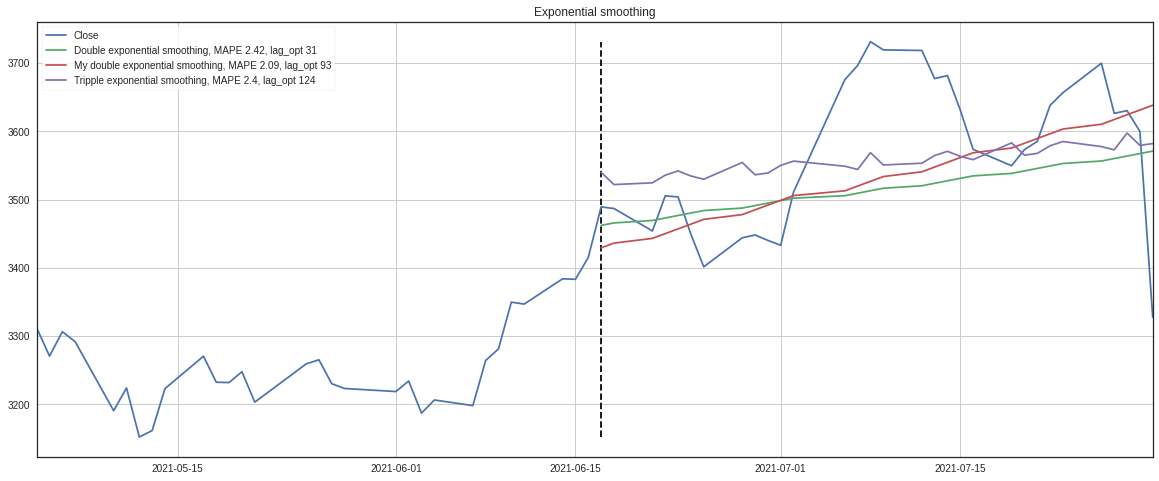

In [8]:
optimize_lag_and_plot_smoothing(amzn_df, 'Date', 'Close')